In [1]:
import datetime

import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [2]:
INPUT_DIR = "input/"

In [ ]:
start = datetime.datetime(202)

In [3]:
data = pd.read_csv(INPUT_DIR + "daily_production.csv")
data['date'] = pd.to_datetime(data['date'])


cond = data['date']

In [4]:
df.head()

,date,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek
0,2005-01-11,1790574.461,35.8,24.0,163.0,53.5,0.0,2005,2,1
1,2005-01-12,2610154.532,97.4,24.0,72.3,43.3,0.0,2005,2,2
2,2005-01-13,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,3
3,2005-01-14,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,4
4,2005-01-15,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,5


<AxesSubplot:>

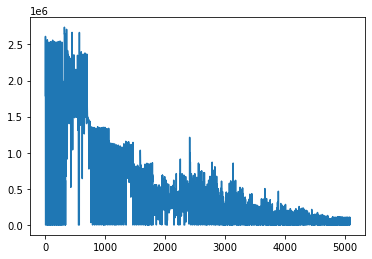

In [5]:
df['gasvol'].plot()

In [6]:
# stringで読み込まれてしまうので小数型（float）にキャストしておく
cols = df.columns[1:]
df[cols] = df[cols].astype("float")
df.index = pd.to_datetime(df["date"])

In [7]:
# Chokeやhrsonlineに異常値がありそう。Choke100％超や24時間超
df.describe()

,gasvol,h20vol,oilvol,bhp,bht,choke,hrsonline,whp,wht,gasinjvol,h20injvol
count,4.718000e+03,0.0,0.0,0.0,0.0,4713.000000,4736.000000,4712.000000,4710.000000,5000.0,5000.0
mean,4.868614e+05,NaN,NaN,NaN,NaN,69.555548,19.452998,30.257789,35.420913,0.0,0.0
std,5.571981e+05,NaN,NaN,NaN,NaN,41.801659,8.501019,20.863258,12.410636,0.0,0.0
min,0.000000e+00,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,-20.000000,0.0,0.0
25%,9.798312e+04,NaN,NaN,NaN,NaN,17.100000,20.200000,19.200000,31.000000,0.0,0.0
50%,2.836414e+05,NaN,NaN,NaN,NaN,96.900000,24.000000,25.200000,38.800000,0.0,0.0
75%,7.028457e+05,NaN,NaN,NaN,NaN,98.800000,24.000000,32.100000,44.200000,0.0,0.0
max,2.737552e+06,NaN,NaN,NaN,NaN,124.000000,25.000000,190.300000,73.900000,0.0,0.0


In [8]:
# 全部同じ値のカラムは不要なので、必要なものだけ抽出しておく。
# 一つでも欠損のあるレコード（行）も除いておく。欠損値の処理は奥が深いが。。 
use_cols = ['gasvol', 'choke', 'hrsonline', 'whp', 'wht']
df = df[use_cols].dropna(how='any')

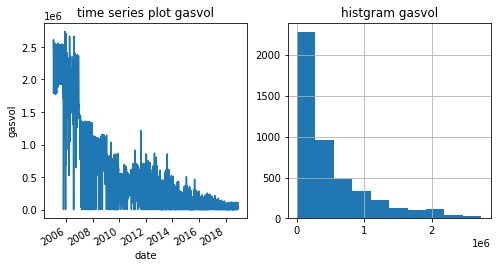

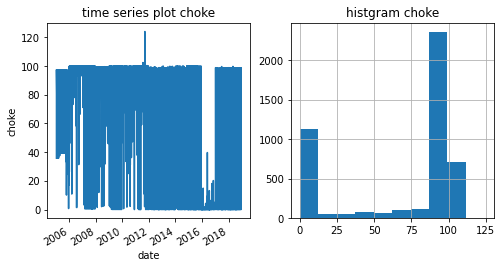

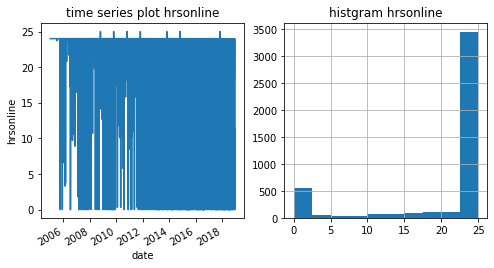

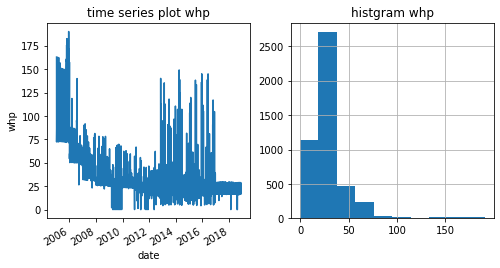

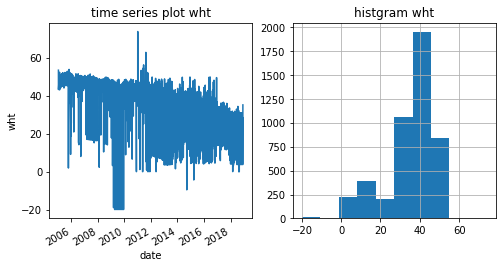

In [9]:
# gasvol: 徐々に低減していく。詳しく見るとhrsonline=0でも生産があったり、24時間でも生産が０だったりする。
# Choke：100超は不正値と考えられる。100に修正する。
# hrsonline:24時間超は不正値。
# whp: 徐々に低減。2014年あたりから振れが大きくなる。とりあえずこのまま
# wht:徐々に低減。生産量やWHPは曲線的な下降だが、WHTは直線的。

for c in use_cols:
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.title(f"time series plot {c}")
    df[c].plot()
    plt.ylabel(c)
    plt.subplot(122)
    plt.title(f"histgram {c}")
    df[c].hist()
    plt.show()

In [10]:
df['hrsonline'] = df['hrsonline'].apply(lambda x:np.clip(x, 0, 24)) # hrsonlineを0−24に制限（クリップ）。飛び出たものは下限、上限に変換される。
df['choke'] = df['choke'].apply(lambda x:np.clip(x, 0, 100)) #0−100％だと考えられるのでクリップ。

In [11]:
# 20時間以上の生産時間の日は75%。生産時間が短い日はレートが安定しないので学習には入れなくても良いかもしれない。
df.describe()

,gasvol,choke,hrsonline,whp,wht
count,4.691000e+03,4691.000000,4691.000000,4691.000000,4691.000000
mean,4.891573e+05,69.855042,19.636623,30.377723,35.554317
std,5.573613e+05,41.632285,8.326384,20.820685,12.238677
min,0.000000e+00,0.000000,0.000000,0.000000,-20.000000
25%,1.011451e+05,22.100000,20.800000,19.400000,31.100000
50%,2.882853e+05,96.900000,24.000000,25.300000,38.800000
75%,7.074036e+05,98.800000,24.000000,32.200000,44.200000
max,2.737552e+06,100.000000,24.000000,190.300000,73.900000


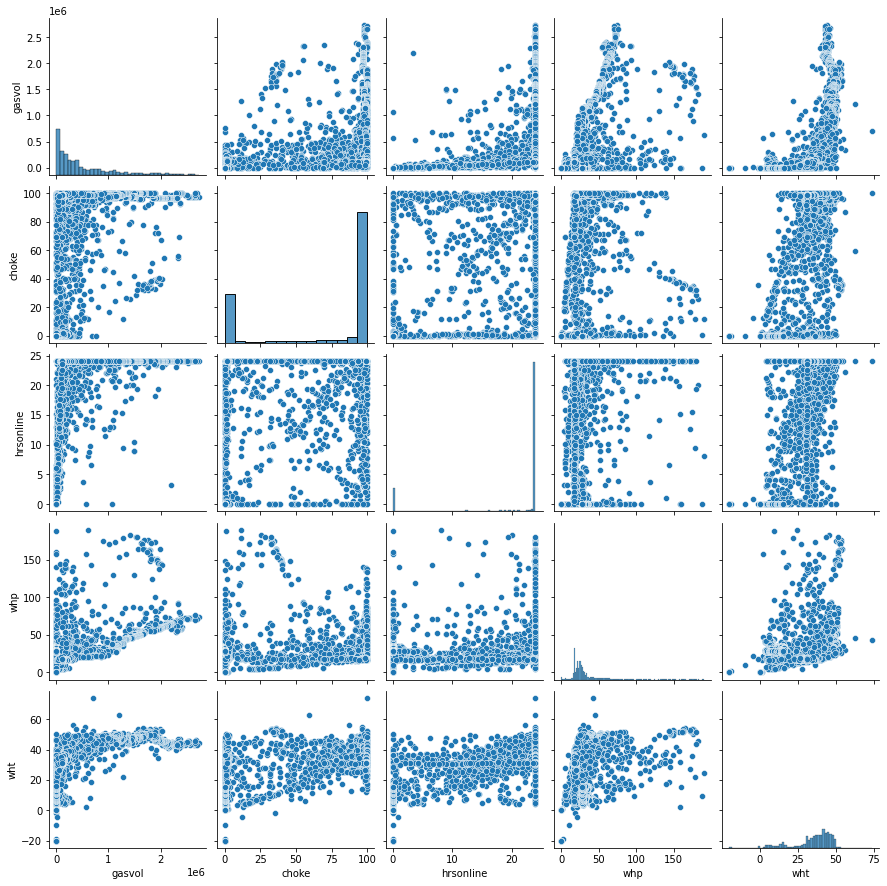

In [12]:
sns.pairplot(df[use_cols])

In [13]:
# 日付の欠損があると、前日の生産量を見るのに困るので、日付には欠損が無いようにする。
df_emp = pd.DataFrame(index = pd.date_range(df.index.min(), df.index.max()))\
                .reset_index(drop=False)\
                .rename(columns={"index":"date"}) #日付だけのデータフレーム

df = pd.merge(df_emp, df, on='date',  how='left').fillna(0).set_index('date') #突合できないものはNullになるので0埋めしておく。

In [14]:
df['hrsoffline'] = 24 - df['hrsonline'] #シャットインしていた時間がモデル訓練時に使えるかもしれない。
df['year'] = df.index.isocalendar().year.astype("int") #日付を特徴量化
df['week'] = df.index.isocalendar().week.astype("int") #日付を特徴量化
df['dayofweek'] = df.index.dayofweek.astype("int") #日付を特徴量化

df.head()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek
date,,,,,,,,,
2005-01-11,1790574.461,35.8,24.0,163.0,53.5,0.0,2005,2,1
2005-01-12,2610154.532,97.4,24.0,72.3,43.3,0.0,2005,2,2
2005-01-13,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,3
2005-01-14,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,4
2005-01-15,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,5


In [15]:
df.to_csv(INPUT_DIR + "daily_production.csv")